<a href="https://colab.research.google.com/github/prabdeepkaur/COA-CODE/blob/main/4_ASSIGNMENT_COA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Optimizing Memory Access in Cache Hierarchies**
# **ASSIGNMENT-4**

In [ ]:
# Cell 1: Imports & setup
import os, json, random, math
from collections import OrderedDict
from dataclasses import dataclass
from typing import Tuple, Optional
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

# create folders in Colab filesystem
os.makedirs('/content/sim', exist_ok=True)
os.makedirs('/content/traces', exist_ok=True)
os.makedirs('/content/plots', exist_ok=True)

print("Folders created: /content/sim, /content/traces, /content/plots")


Folders created: /content/sim, /content/traces, /content/plots


In [ ]:
# Cell 2: Write default config.json (edit this file later to change parameters)
default_config = {
    "L1": {
        "size_bytes": 32 * 1024,
        "associativity": 4,
        "block_size": 64,
        "replacement": "LRU",
        "write_policy": "write-back",   # "write-back" or "write-through"
        "write_allocate": True
    },
    "L2": {
        "size_bytes": 256 * 1024,
        "associativity": 8,
        "block_size": 64,
        "replacement": "LRU",
        "write_policy": "write-back",
        "write_allocate": True
    },
    "latencies": {
        "L1_hit": 1,
        "L2_hit": 10,
        "memory": 100
    }
}
with open('/content/sim/config.json', 'w') as f:
    json.dump(default_config, f, indent=2)
print("Wrote /content/sim/config.json with defaults.")


Wrote /content/sim/config.json with defaults.


In [ ]:

#sub problem-1
# Cell 3: Cache classes (L1+L2), supports associativity, LRU, write-through / write-back
@dataclass
class CacheLine:
    tag: int
    valid: bool = True
    dirty: bool = False

class Set:
    def __init__(self, ways: int):
        self.ways = ways
        self.lines = OrderedDict()  # tag -> CacheLine; left=L R U, right=M R U

    def access(self, tag: int, is_write: bool, write_allocate: bool, write_policy: str) -> Tuple[bool, Optional[CacheLine], bool]:
        """Return (hit, evicted_line_or_None, evicted_was_dirty)."""
        if tag in self.lines:
            line = self.lines.pop(tag)
            self.lines[tag] = line  # move to MRU
            if is_write and write_policy == 'write-back':
                line.dirty = True
            return True, None, False

        # Miss
        if not write_allocate and is_write:
            # write-no-allocate behavior
            return False, None, False

        # Evict if needed
        evicted_line = None
        evicted_was_dirty = False
        if len(self.lines) >= self.ways:
            ev_tag, ev_line = self.lines.popitem(last=False)  # pop LRU
            evicted_line = ev_line
            evicted_was_dirty = ev_line.dirty

        new_line = CacheLine(tag=tag, valid=True, dirty=(is_write and write_policy == 'write-back'))
        self.lines[tag] = new_line
        return False, evicted_line, evicted_was_dirty

class CacheLevel:
    def __init__(self, size_bytes:int, associativity:int, block_size:int, replacement:str, write_policy:str, write_allocate:bool, name:str='L'):
        self.size = size_bytes
        self.assoc = associativity
        self.block = block_size
        self.num_sets = max(1, size_bytes // (block_size * associativity))
        self.sets = [Set(associativity) for _ in range(self.num_sets)]
        self.write_policy = write_policy
        self.write_allocate = write_allocate
        self.name = name

    def _index_and_tag(self, addr:int):
        block_addr = addr // self.block
        idx = block_addr % self.num_sets
        tag = block_addr // self.num_sets
        return idx, tag

    def access(self, addr:int, is_write:bool):
        idx, tag = self._index_and_tag(addr)
        return self.sets[idx].access(tag, is_write, self.write_allocate, self.write_policy)

class TwoLevelCache:
    def __init__(self, cfg:dict):
        self.L1 = CacheLevel(cfg['L1']['size_bytes'], cfg['L1']['associativity'], cfg['L1']['block_size'],
                             cfg['L1'].get('replacement','LRU'), cfg['L1'].get('write_policy','write-back'),
                             cfg['L1'].get('write_allocate',True), name='L1')
        self.L2 = CacheLevel(cfg['L2']['size_bytes'], cfg['L2']['associativity'], cfg['L2']['block_size'],
                             cfg['L2'].get('replacement','LRU'), cfg['L2'].get('write_policy','write-back'),
                             cfg['L2'].get('write_allocate',True), name='L2')
        self.latencies = cfg.get('latencies', {'L1_hit':1,'L2_hit':10,'memory':100})
        self.reset_stats()

    def reset_stats(self):
        self.stats = {
            'accesses':0, 'reads':0, 'writes':0,
            'L1_hits':0, 'L1_misses':0, 'L2_hits':0, 'L2_misses':0,
            'memory_accesses':0, 'writebacks_to_mem':0
        }

    def access(self, addr:int, is_write:bool):
        self.stats['accesses'] += 1
        if is_write: self.stats['writes'] += 1
        else: self.stats['reads'] += 1

        # L1
        L1_hit, evL1, ev_dirty_L1 = self.L1.access(addr, is_write)
        if L1_hit:
            self.stats['L1_hits'] += 1
            return 'L1'
        self.stats['L1_misses'] += 1

        # L2
        L2_hit, evL2, ev_dirty_L2 = self.L2.access(addr, is_write)
        if L2_hit:
            self.stats['L2_hits'] += 1
            # bring into L1
            self.L1.access(addr, is_write)
            if evL2 and ev_dirty_L2:
                self.stats['writebacks_to_mem'] += 1
                self.stats['memory_accesses'] += 1
            return 'L2'

        # Memory
        self.stats['L2_misses'] += 1
        self.stats['memory_accesses'] += 1

        # allocate in L2 and L1 (handle evictions)
        _, ev2b, ev2b_dirty = self.L2.access(addr, False)
        if ev2b and ev2b_dirty:
            self.stats['writebacks_to_mem'] += 1
            self.stats['memory_accesses'] += 1
        self.L1.access(addr, is_write)
        return 'MEM'

    def get_stats(self):
        s = self.stats.copy()
        s['L1_hit_rate'] = s['L1_hits'] / s['accesses'] if s['accesses'] else 0
        s['L2_hit_rate'] = s['L2_hits'] / (s['L1_misses']) if s['L1_misses'] else 0
        s['AMAT'] = (self.latencies['L1_hit'] +
                     (1 - s['L1_hit_rate']) *
                     (self.latencies['L2_hit'] +
                      (1 - s['L2_hit_rate']) * self.latencies['memory']))
        return s

print("Simulator classes defined (supports LRU, associativity, write-back/write-through).")


Simulator classes defined (supports LRU, associativity, write-back/write-through).


In [ ]:
# Cell 4: Write a plain simulator source file (text) into /content/sim/cache_simulator.py
sim_text = '''
# Simple 2-level cache simulator source (auto-generated)
# This file is a plain text fallback; real classes live in the notebook runtime.
from collections import OrderedDict
from dataclasses import dataclass
@dataclass
class CacheLine:
    tag:int
    valid:bool=True
    dirty:bool=False
# ... (shortened copy) ...
# Use the notebook classes for execution.
'''
with open('/content/sim/cache_simulator.py', 'w') as f:
    f.write(sim_text)
print("Wrote a descriptive cache_simulator.py to /content/sim/ (use notebook runtime classes for simulation).")


Wrote a descriptive cache_simulator.py to /content/sim/ (use notebook runtime classes for simulation).


In [ ]:
#sub problem-2
# Cell 5: Load traces (if any) from /content/traces/ ; else generate synthetic traces
def load_traces(folder='/content/traces'):
    traces = {}
    for fname in sorted(os.listdir(folder)):
        path = os.path.join(folder, fname)
        if os.path.isfile(path):
            with open(path) as f:
                lines = [ln.strip() for ln in f if ln.strip()]
            parsed=[]
            for ln in lines:
                parts = ln.split()
                if len(parts)>=2:
                    op = parts[0].upper()
                    try:
                        addr = int(parts[1],0)
                    except:
                        continue
                    if op in ('R','W'):
                        parsed.append((op, addr))
            if parsed:
                traces[fname]=parsed
    return traces

def gen_synth(n=5000, ws=16384, pattern='working_set'):
    t=[]
    for i in range(n):
        if pattern=='stream':
            addr = (i*64) % (ws*16)
            op='R'
        elif pattern=='random':
            addr = random.randint(0, ws*16)
            op = random.choice(['R','W'])
        else:
            addr = random.randint(0, ws//64)*64
            op = 'R' if random.random()<0.8 else 'W'
        t.append((op, addr))
    return t

traces = load_traces()
if not traces:
    print("No traces found in /content/traces. Generating synthetic traces...")
    t1 = gen_synth(n=5000, ws=16384, pattern='working_set')
    t2 = gen_synth(n=2000, ws=65536, pattern='stream')
    with open('/content/traces/synthetic_working_set.txt','w') as f:
        for op,a in t1: f.write(f"{op} {hex(a)}\n")
    with open('/content/traces/synthetic_stream.txt','w') as f:
        for op,a in t2: f.write(f"{op} {hex(a)}\n")
    traces = load_traces()
print("Traces available:", list(traces.keys()))


Traces available: ['sample_trace.txt']


In [ ]:
#sub problem-2
# Cell 6: Run simulator on one trace and print stats (choose config or edit config.json)
with open('/content/sim/config.json') as f:
    cfg = json.load(f)

# pick first trace
tname = next(iter(traces))
trace = traces[tname]
sim = TwoLevelCache(cfg)
for op, addr in trace:
    sim.access(addr, op=='W')
stats = sim.get_stats()
print(f"Trace: {tname}")
print("Accesses:", stats['accesses'])
print("L1 hit rate:", stats['L1_hit_rate'])
print("L2 hit rate (on L1 misses):", stats['L2_hit_rate'])
print("AMAT (cycles):", stats['AMAT'])
# Save per-trace summary CSV
pd.DataFrame([stats]).to_csv('/content/plots/trace_summary_' + tname + '.csv', index=False)
print("Saved summary CSV to /content/plots/")



Trace: sample_trace.txt
Accesses: 5000
L1 hit rate: 0.9374
L2 hit rate (on L1 misses): 0.0
AMAT (cycles): 7.885999999999999
Saved summary CSV to /content/plots/


In [ ]:
#(Sub-problem 3)
# Cell 7: Sweep L1/L2 sizes and write policies; produce plots with seaborn
with open('/content/sim/config.json') as f:
    base_cfg = json.load(f)

L1_sizes = [8*1024, 16*1024, 32*1024]    # adjust if needed
L2_sizes = [128*1024, 256*1024]
policies = ['write-back','write-through']

rows=[]
for L1 in L1_sizes:
    for L2 in L2_sizes:
        for pol in policies:
            cfg = json.loads(json.dumps(base_cfg))
            cfg['L1']['size_bytes']=L1
            cfg['L2']['size_bytes']=L2
            cfg['L1']['write_policy']=pol
            cfg['L2']['write_policy']=pol
            for tname, trace in traces.items():
                sim = TwoLevelCache(cfg)
                for op, addr in trace:
                    sim.access(addr, op=='W')
                s = sim.get_stats()
                rows.append({'trace':tname,'L1_kB':L1//1024,'L2_kB':L2//1024,'policy':pol,'L1_hit_rate':s['L1_hit_rate'],'AMAT':s['AMAT'],'memory_accesses':s['memory_accesses']})

df = pd.DataFrame(rows)
df.to_csv('/content/plots/sweep_results.csv', index=False)
print("Saved sweep_results.csv")

# Plots: L1 hit rate vs L1 size
sns.set(style='whitegrid')
plt.figure(figsize=(8,4))
ax = sns.lineplot(data=df, x='L1_kB', y='L1_hit_rate', hue='policy', style='trace', markers=True)
ax.set_title('L1 Hit Rate vs L1 size')
ax.set_xlabel('L1 (kB)')
ax.set_ylabel('L1 hit rate')
plt.savefig('/content/plots/L1_hit_rate_vs_L1_size.png', bbox_inches='tight')
plt.close()

# AMAT plot
plt.figure(figsize=(8,4))
ax = sns.lineplot(data=df, x='L1_kB', y='AMAT', hue='policy', style='trace', markers=True)
ax.set_title('AMAT vs L1 size')
ax.set_xlabel('L1 (kB)')
ax.set_ylabel('AMAT')
plt.savefig('/content/plots/AMAT_vs_L1_size.png', bbox_inches='tight')
plt.close()

# Combined PDF
with PdfPages('/content/plots/cache_analysis_plots.pdf') as pdf:
    fig = plt.figure(figsize=(8,4))
    sns.lineplot(data=df, x='L1_kB', y='L1_hit_rate', hue='policy', style='trace', markers=True)
    plt.title('L1 Hit Rate vs L1 size')
    pdf.savefig()
    plt.close()
    fig = plt.figure(figsize=(8,4))
    sns.lineplot(data=df, x='L1_kB', y='AMAT', hue='policy', style='trace', markers=True)
    plt.title('AMAT vs L1 size')
    pdf.savefig()
    plt.close()

print("Saved plots to /content/plots/")


Saved sweep_results.csv
Saved plots to /content/plots/


In [ ]:
#Sub-problem 4)
# Cell 8: Programmed I/O vs DMA simulation (cycles), plot and create pdf
def simulate_io_transfer(size_bytes:int, programmed_cycles_per_byte:float=5.0, dma_setup_cost:float=500.0, dma_cycles_per_byte:float=0.5):
    programmed_cpu = size_bytes * programmed_cycles_per_byte
    programmed_wall = programmed_cpu
    dma_cpu = dma_setup_cost + max(1, size_bytes//4096)*10
    dma_wall = dma_setup_cost + size_bytes * dma_cycles_per_byte
    return {'size_bytes':size_bytes,'programmed_cpu':programmed_cpu,'programmed_wall':programmed_wall,'dma_cpu':dma_cpu,'dma_wall':dma_wall}

sizes = list(range(256, 2*1024*1024+1, 8192))
io_rows=[simulate_io_transfer(s) for s in sizes]
df_io = pd.DataFrame(io_rows)
df_io.to_csv('/content/plots/io_simulation.csv', index=False)

plt.figure(figsize=(8,4))
sns.lineplot(data=df_io, x='size_bytes', y='programmed_cpu', label='Programmed CPU')
sns.lineplot(data=df_io, x='size_bytes', y='dma_cpu', label='DMA CPU')
plt.xscale('log'); plt.title('CPU cycles vs Transfer size'); plt.xlabel('bytes')
plt.savefig('/content/plots/io_cpu_cycles.png', bbox_inches='tight')
plt.close()

plt.figure(figsize=(8,4))
sns.lineplot(data=df_io, x='size_bytes', y='programmed_wall', label='Programmed wall')
sns.lineplot(data=df_io, x='size_bytes', y='dma_wall', label='DMA wall')
plt.xscale('log'); plt.title('Wall-clock vs Transfer size'); plt.xlabel('bytes')
plt.savefig('/content/plots/io_wallclock.png', bbox_inches='tight')
plt.close()

io_report = (
    "I/O Strategy Analysis\\n\\n"
    "Assumptions:\\n- PIO: ~5 cycles/byte on CPU.\\n- DMA: setup ~500 cycles, transfer ~0.5 cycles/byte (device).\\n\\n"
    "Observations:\\n- For small sizes, PIO may be comparable; for larger sizes DMA is far superior in CPU usage.\\n"
)
with PdfPages('/content/io_strategy_analysis.pdf') as pdf:
    fig, ax = plt.subplots(figsize=(8.5,11)); ax.axis('off'); ax.text(0.01,0.99,io_report,va='top',wrap=True,fontsize=10)
    pdf.savefig(); plt.close()

print("I/O simulation files and /content/io_strategy_analysis.pdf created.")


I/O simulation files and /content/io_strategy_analysis.pdf created.


In [ ]:
#sub problem-5
# Cell 9: Write 1-page reflection PDF and print deliverables
reflection = (
    "When do memory optimizations matter most?\\n\\n"
    "Memory optimizations matter when the working set exceeds the fastest memory levels or when latency is critical.\\n"
    "Embedded: limited memory and power -> small caches or deterministic accesses; Server/HPC: large datasets -> bandwidth and cache locality matter.\\n"
    "Techniques: blocking, prefetching, data layout changes, NUMA-aware allocation, minimizing pointer-chasing.\\n"
)
with PdfPages('/content/plots/memory_optimization_reflection.pdf') as pdf:
    fig, ax = plt.subplots(figsize=(8.5,11)); ax.axis('off'); ax.text(0.01,0.99,reflection,va='top',wrap=True,fontsize=10)
    pdf.savefig(); plt.close()
with open('/content/plots/memory_optimization_reflection.txt','w') as f: f.write(reflection)

print("Deliverables created:")
print("- /content/sim/cache_simulator.py  (descriptive file)")
print("- /content/sim/config.json")
print("- /content/traces/ (place your traces here)")
print("- /content/plots/sweep_results.csv")
print("- /content/plots/L1_hit_rate_vs_L1_size.png")
print("- /content/plots/AMAT_vs_L1_size.png")
print("- /content/plots/cache_analysis_plots.pdf")
print("- /content/plots/io_simulation.csv")
print("- /content/plots/io_cpu_cycles.png")
print("- /content/plots/io_wallclock.png")
print("- /content/io_strategy_analysis.pdf")
print("- /content/plots/memory_optimization_reflection.pdf")


Deliverables created:
- /content/sim/cache_simulator.py  (descriptive file)
- /content/sim/config.json
- /content/traces/ (place your traces here)
- /content/plots/sweep_results.csv
- /content/plots/L1_hit_rate_vs_L1_size.png
- /content/plots/AMAT_vs_L1_size.png
- /content/plots/cache_analysis_plots.pdf
- /content/plots/io_simulation.csv
- /content/plots/io_cpu_cycles.png
- /content/plots/io_wallclock.png
- /content/io_strategy_analysis.pdf
- /content/plots/memory_optimization_reflection.pdf


Sweep complete — starting plots...


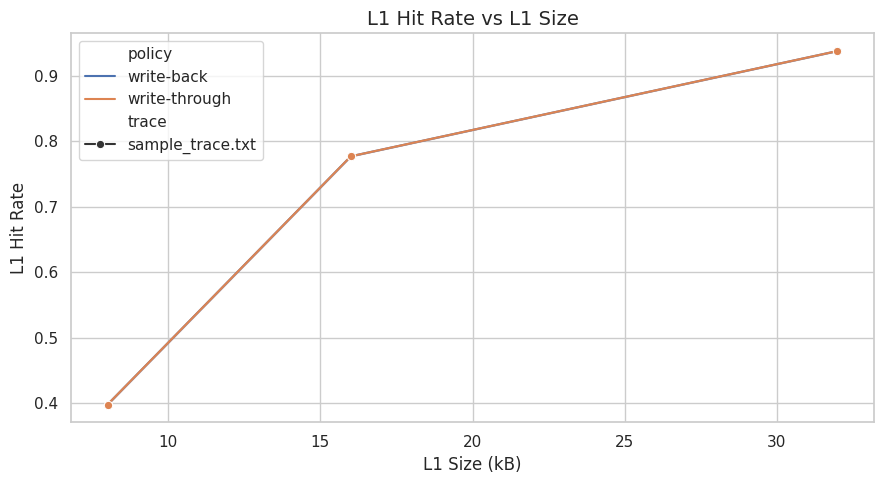

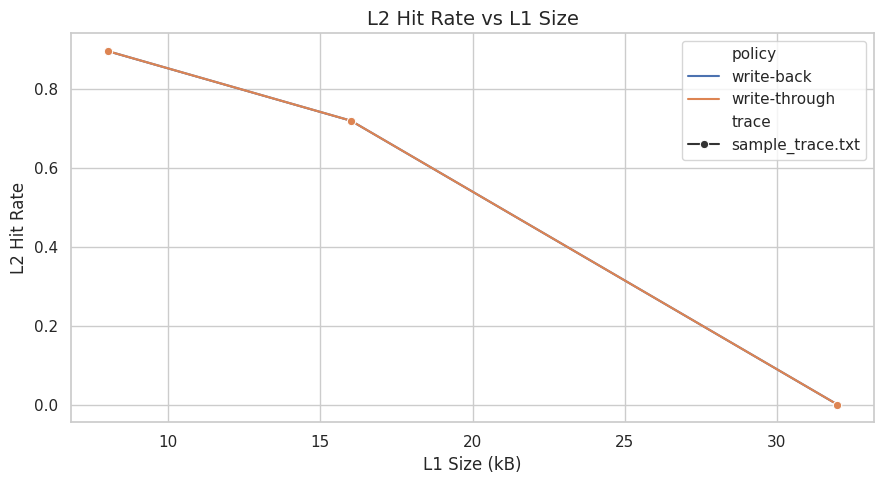

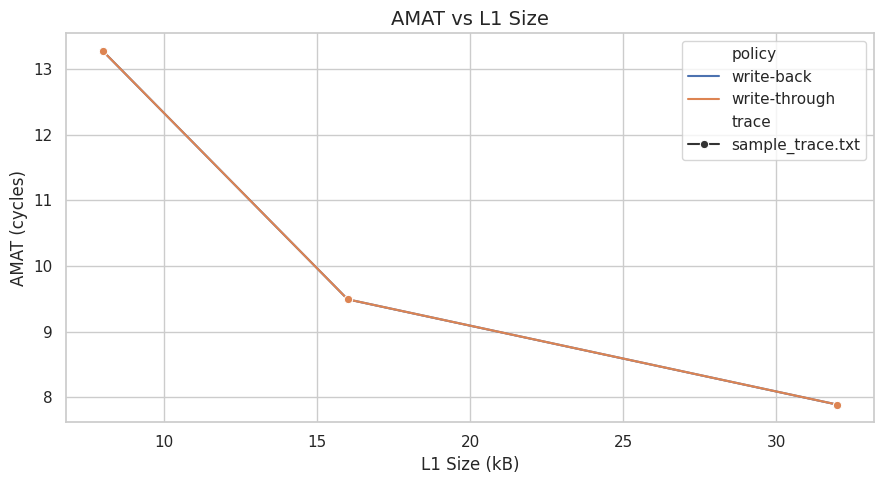

All graphs saved in /content/plots/


In [ ]:
# ==== CLEAN WORKING GRAPH GENERATION ====
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
sns.set(style="whitegrid")

def run_cache(cfg, trace):
    sim = TwoLevelCache(cfg)
    for op, addr in trace:
        sim.access(addr, op == "W")
    return sim.get_stats()

with open('/content/sim/config.json') as f:
    base_cfg = json.load(f)

# Sweep parameters
L1_sizes = [8*1024, 16*1024, 32*1024]
L2_sizes = [128*1024, 256*1024]
policies = ["write-back", "write-through"]

results = []

for L1 in L1_sizes:
    for L2 in L2_sizes:
        for pol in policies:
            cfg = json.loads(json.dumps(base_cfg))
            cfg["L1"]["size_bytes"] = L1
            cfg["L2"]["size_bytes"] = L2
            cfg["L1"]["write_policy"] = pol
            cfg["L2"]["write_policy"] = pol

            for tname, trace in traces.items():
                stats = run_cache(cfg, trace)
                results.append({
                    "trace": tname,
                    "L1_kB": L1 // 1024,
                    "L2_kB": L2 // 1024,
                    "policy": pol,
                    "L1_hit_rate": stats["L1_hit_rate"],
                    "L2_hit_rate": stats["L2_hit_rate"],
                    "AMAT": stats["AMAT"]
                })

df = pd.DataFrame(results)
df.to_csv("/content/plots/sweep_results_clean.csv", index=False)

print("Sweep complete — starting plots...")

# ***** PLOT 1 — L1 HIT RATE vs L1 SIZE *****
plt.figure(figsize=(9,5))
sns.lineplot(data=df, x="L1_kB", y="L1_hit_rate", hue="policy", style="trace", markers=True)
plt.title("L1 Hit Rate vs L1 Size", fontsize=14)
plt.xlabel("L1 Size (kB)")
plt.ylabel("L1 Hit Rate")
plt.tight_layout()
plt.savefig("/content/plots/L1_hit_rate_lineplot.png")
plt.show()

# ***** PLOT 2 — L2 HIT RATE vs L1 SIZE *****
plt.figure(figsize=(9,5))
sns.lineplot(data=df, x="L1_kB", y="L2_hit_rate", hue="policy", style="trace", markers=True)
plt.title("L2 Hit Rate vs L1 Size", fontsize=14)
plt.xlabel("L1 Size (kB)")
plt.ylabel("L2 Hit Rate")
plt.tight_layout()
plt.savefig("/content/plots/L2_hit_rate_lineplot.png")
plt.show()

# ***** PLOT 3 — AMAT vs L1 SIZE *****
plt.figure(figsize=(9,5))
sns.lineplot(data=df, x="L1_kB", y="AMAT", hue="policy", style="trace", markers=True)
plt.title("AMAT vs L1 Size", fontsize=14)
plt.xlabel("L1 Size (kB)")
plt.ylabel("AMAT (cycles)")
plt.tight_layout()
plt.savefig("/content/plots/AMAT_lineplot.png")
plt.show()

# ***** PDF with all plots *****
with PdfPages("/content/plots/cache_graphs.pdf") as pdf:
    for img in ["L1_hit_rate_lineplot.png", "L2_hit_rate_lineplot.png", "AMAT_lineplot.png"]:
        fig = plt.figure(figsize=(9,5))
        plt.imshow(plt.imread(f"/content/plots/{img}"))
        plt.axis("off")
        pdf.savefig()
        plt.close()

print("All graphs saved in /content/plots/")
